In [179]:
import os
import re
import numpy as np

def retrieve_fidelity_dict(base_dir):
    # Dictionary to hold costs organized by prefix (i)
    fidelity_dict = {}
    
    # Iterate through each subfolder in the base directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            # Extract the prefix for identifying the 'i' value
            prefix = folder_name.split('_')[0]
            # Path to the cost.txt file
            cost_file_path = os.path.join(folder_path, 'fidelity.txt')
            
            # Read the cost value from the cost.txt file
            if os.path.exists(cost_file_path):
                    with open(cost_file_path, 'r') as file:
                        # Extract the complex number part using regular expression
                        complex_str = file.read().strip()
                        # Convert the extracted string to a complex number
                        complex_number = complex(complex_str)
                        # Get the real part and convert to float
                        float_value = complex_number.real
                        if prefix not in fidelity_dict:
                            fidelity_dict[prefix] = []
                        fidelity_dict[prefix].append(abs(float_value))
    
    return fidelity_dict

# Define the base directory where the folders are located
base_directory = 'experiment_result_2'

# Retrieve costs and convert to matrix
fidelity_dict_rho_rho3 = retrieve_fidelity_dict(base_directory)


In [180]:
import tensorflow as tf
import numpy as np
import re
import epsilon_rho
import metrics

# Function to read and parse the tensor data from a text file
def parse_tensor_from_file(file_path, shape):
    with open(file_path, 'r') as file:
        # Read the content of the file
        tensor_str = file.read()
        # Regular expression to match complex numbers
        # The pattern captures real and imaginary parts
        pattern = r'[-+]?\d*\.\d+(?:[eE][-+]?\d+)?'

        # Find all matches in the string
        matches = re.findall(pattern, tensor_str)

    # Convert string to a NumPy array
    numpy_tensor = np.array(matches, dtype=np.complex128)
    if (shape == 3):
        numpy_tensor = numpy_tensor.reshape(round(numpy_tensor.size ** (1/shape)),round(numpy_tensor.size ** (1/shape)),round(numpy_tensor.size ** (1/shape)))
    if (shape == 2):
         numpy_tensor = numpy_tensor.reshape(round(numpy_tensor.size ** (1/shape)),round(numpy_tensor.size ** (1/shape)))
    # Convert NumPy array to TensorFlow tensor
    tf_tensor = tf.convert_to_tensor(numpy_tensor)

    return tf_tensor

from qoop.core import state, ansatz, metric
from qiskit.quantum_info import DensityMatrix
def retrieve_fidelity_dict_from_tensor(base_dir):
    # Dictionary to hold costs organized by prefix (i)
    fidelity_dict = {}
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)

        if os.path.isdir(folder_path):
            # Extract the prefix for identifying the 'i' value
            prefix = folder_name.split('_')[0]

            kraus_file_path = os.path.join(folder_path, 'kraus_operators.txt')
            kraus_operators = parse_tensor_from_file(kraus_file_path, 3)

            rho2_file_path = os.path.join(folder_path, 'rho2.txt')
            rho2 = parse_tensor_from_file(rho2_file_path, 2)
            
            rho_file_path = os.path.join(base_dir, prefix+'_qubits_rho.txt')
            rho= parse_tensor_from_file(rho_file_path, 2)

            out_rho2 = epsilon_rho.calculate_from_kraus_operators(rho=rho, kraus_operators=kraus_operators)
            #out_rho2 = np.transpose(np.conjugate(out_rho2))
            
            fildelity = abs(1 - metrics.compilation_trace_fidelity(rho2, out_rho2))
            if prefix not in fidelity_dict:
                fidelity_dict[prefix] = []
            fidelity_dict[prefix].append((fildelity))

    return fidelity_dict

fidelity_dict_rho_rho2 = retrieve_fidelity_dict_from_tensor('experiment_result_2')



In [181]:
import matplotlib.pyplot as plt

def plot_fidelity (fidelity_dict, ylabel, file_name):
    # Plotting
    plt.figure(figsize=(10, 6))

    colorList = ['r', 'g', 'b', 'magenta', 'orange']
    # Plot each category
    for key, values in fidelity_dict.items():
        color = colorList[int(key) - 1]
        plt.plot(values, label=key, color = color)
    
    # Adding title and labels
    plt.xlabel('Gamma')
    plt.ylabel(ylabel)

    plt.yscale('log')  # Set y-axis to logarithmic scale
    # Customizing x-axis ticks
    x_ticks = np.arange(0, 20, step=2)  # Adjust step size based on your data
    x_tick_labels = [f'{tick/20:.2f}' for tick in x_ticks]  # Convert to float and format
    plt.xticks(ticks=x_ticks, labels=x_tick_labels)
    
    plt.savefig('docs/'+file_name+'.png', format='png')
    plt.savefig('docs/'+file_name+'.eps', format='eps')
    plt.legend()

    # Display the plot
    plt.show()
    

0
1
2
3
4


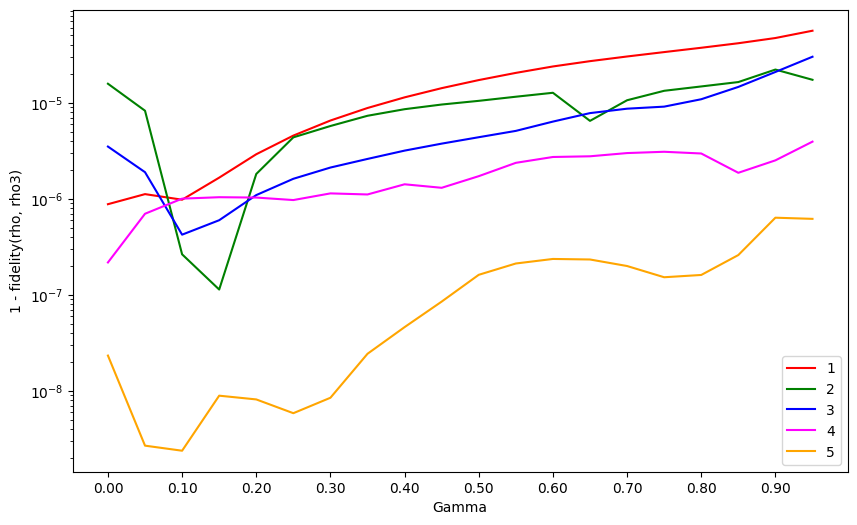

In [182]:
plot_fidelity(fidelity_dict_rho_rho3, '1 - fidelity(rho, rho3)', 'output_rho-rho3')

0
1
2
3
4


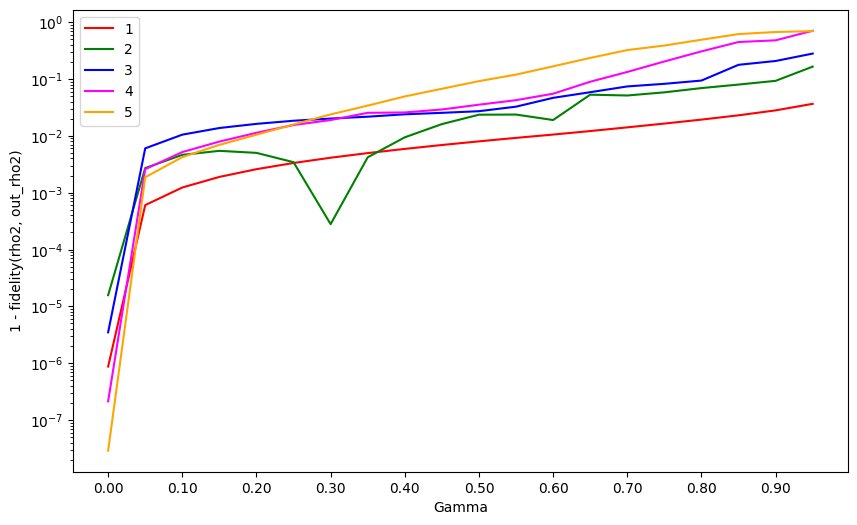

In [183]:
plot_fidelity(fidelity_dict_rho_rho2, '1 - fidelity(rho2, out_rho2)', 'output_rho2-out_rho2')

In [184]:
def kron_n_identity(n, j, matrix):
    """
    Kronecker product of n identity matrices, except at position j where we place the matrix.
    """
    # Create the tensor product of Pauli-Z matrices for all qubits
    result = np.eye(1)
    for i in range(n):
        
        if j == i:
            result = np.kron(result, matrix)
        else:
            result = np.kron(result, np.eye(2))
    return result

def compute_M(rho2, rho2_kraus, j):
    """
    Compute M_j(t) = <psi(t) | sigma_z_j | psi2(t)>
    
    Parameters:
    - psi: density matrix psi(t) (2^n x 2^n complex matrix)
    - j: qubit index to apply sigma_z on (0-based index)
    
    Returns:
    - Expectation value M_j(t)
    """
    # Define Pauli-Z matrix
    pauli_z = np.array([[1, 0], [0, -1]])
    # Get number of qubits (assuming psi is a 2^n x 2^n matrix)
    n = int(np.log2(rho2.shape[0]))

    # Construct the operator sigma_z_j, acting on qubit j
    sigma_z_j = kron_n_identity(n, j, pauli_z)
    # Compute the expectation value <psi | sigma_z_j | psi2>
    M_j_t =np.trace(sigma_z_j @ rho2)
    M_j_t2=np.trace(sigma_z_j @ rho2_kraus)
    return np.real(M_j_t), np.real(M_j_t2)


In [185]:
import epsilon_rho
import init

def retrieve_M_dict(base_dir):
     # Iterate through each subfolder in the base directory
     M_dict = {}
     M_dict2 = {}
     for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            # Extract the prefix for identifying the 'i' value
            prefix = folder_name.split('_')[0]
            # Path to the cost.txt file
     
            kraus_file_path = os.path.join(folder_path, 'kraus_operators.txt')
            kraus_operators = parse_tensor_from_file(kraus_file_path, 3)

            rho_file_path = os.path.join(folder_path, 'rho2.txt')
            rho2 = parse_tensor_from_file(rho_file_path, 2)
            rho=init.create_plus_state(int(prefix))
            out_rho2 = epsilon_rho.calculate_from_kraus_operators(rho=rho, kraus_operators=kraus_operators)
            out_rho2 = np.transpose(np.conjugate(out_rho2))
            print(out_rho2)
            M_0, M_0_2 = compute_M(rho2, out_rho2, 0)
            if prefix not in M_dict:
                 M_dict[prefix] = []
                 M_dict2[prefix] = []
            M_dict[prefix].append((M_0))
            M_dict2[prefix].append((M_0_2))
     return (M_dict, M_dict2)

M_dict, M_dict2 = retrieve_M_dict('experiment_result_2')
# Prepare the matrix
print(M_dict)

[[0.7672963 -0.j 0.04090016-0.j]
 [0.04090016-0.j 0.33119553-0.j]]
[[0.77076395-0.j 0.03683063-0.j]
 [0.03683063-0.j 0.34871201-0.j]]
[[0.77276747-0.j 0.03718004-0.j]
 [0.03718004-0.j 0.35480435-0.j]]
[[0.77410355-0.j 0.03953234-0.j]
 [0.03953234-0.j 0.35638198-0.j]]
[[0.77515743-0.j 0.04283487-0.j]
 [0.04283487-0.j 0.35642174-0.j]]
[[0.77606469-0.j 0.04686955-0.j]
 [0.04686955-0.j 0.35545978-0.j]]
[[0.7769211 -0.j 0.05155566-0.j]
 [0.05155566-0.j 0.35362925-0.j]]
[[0.77781469-0.j 0.05683073-0.j]
 [0.05683073-0.j 0.35103833-0.j]]
[[0.77882362-0.j 0.06264892-0.j]
 [0.06264892-0.j 0.34780367-0.j]]
[[0.78001175-0.j 0.06899262-0.j]
 [0.06899262-0.j 0.34404103-0.j]]
[[0.78142437-0.j 0.07588774-0.j]
 [0.07588774-0.j 0.33984176-0.j]]
[[0.78307372-0.j 0.08343872-0.j]
 [0.08343872-0.j 0.33521118-0.j]]
[[0.78481379-0.j 0.09203618-0.j]
 [0.09203618-0.j 0.32979626-0.j]]
[[0.78894001-0.j 0.09833268-0.j]
 [0.09833268-0.j 0.3244077 -0.j]]
[[0.79529875-0.j 0.10273508-0.j]
 [0.10273508-0.j 0.31973312-0